In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [386]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score
from rfpimp import permutation_importances


In [4]:
df_courses = pd.read_csv('data/courses_2.csv', index_col =0)

In [5]:
df_assessments = pd.read_csv('data/assessments.csv', index_col =0)

In [6]:
df_vle = pd.read_csv('data/vle.csv', index_col =0)

In [7]:
df_studentInfo = pd.read_csv('data/studentInfo_2.csv', index_col =0)

In [8]:
df_studentRegistration = pd.read_csv('data/studentRegistration.csv', index_col =0)

In [9]:
df_studentAssessment = pd.read_csv('data/studentAssessment.csv', index_col =0)

In [10]:
df_studentVle_vle = pd.read_csv('data/studentVle_by_vle.csv', index_col =0)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [11]:
df_studentVle_day = pd.read_csv('data/studentVle_by_day.csv', index_col =0)

## Summary of Findings from Exploration


### Courses
* 7 Total Modules
* data covers 4 "semesters" - Feb 2013, Oct 2013, Feb 2014, Oct 2014
* Each Module has 2-4 presentations, all of varying presentation length, but avg is 255 days (8.5mos)
* Modules - BBB, DDD, and FFF were offered each semester.
* Modules - AAA, CCC were offered in only 2 semesters
* Modules -- EEE, GGG were offered in 3 semesters
* Reason they list CCC, EEE, and GGG modules is due to them being "uneven" offered in 3 out of 4 semesters, or in CC's case, offerred in consecutive semesters, rather than in same one every yr like AAA.

### Assessments
* All Presentations have the same amount of Assessments every semester EXCEPT for BBB - 2014J (half the amount of assessments due to removing CMA assessments) and DDD - 2013B (double the amount of assessments due to having CMA assessments). 
* Weights always equal 200 for all presentations except for GGG (weight = 100. only its final exam carries any wieght and for CCC which has two final exams (weight =300)
* Dates tell you at what pt in presentation was the assessment held. Could add feature of % of class completed/progress....


### VLE
* There are 20 unique types of VLE. Some appear much more frequently than others
* Week_from and Week_to are only filled in around 1/6th of time - mainly for url, oucontent, page, questionnarie, resource, and subpage
* Each presentation has a different amount of VLE and it fluctuates from 100 - 500+


### StudentInfo
* Most students in dataset only took 1 Module-Presentation(84%)
* 11% of students took 2
* Most taken Module-Presentations were CCC-2014J and FFF-2014J (7%+ each). 
* Least taken Module-Presentations were AAA-2013J and AAA-2014J (<1.2% each)

###### Target Var - Final Result
* Final Result - 37% Pass, 31% Withdraw, 21% Fail, 9% Distinction
* If I change Final_Result to Pass = Pass+Distinction and Fail = Fail+Withdrawn, then Id have close to a balanced class

######  Demographic var frequency
* 8 Demographic Vars given
* Gender: 54% M, 46% F
* Region: Scotland and East Anglian region (10%+ each), London Region (9.8%). Least is Ireland (3.6%)
* Highest Education: A Level or Equivalent - 43%. Lower than A level - 40%. HE Qualification - 14%
* (https://www.quora.com/What-is-the-American-equivalent-of-A-Level)
* (https://universitycompare.com/advice/student/what-is-a-certificate-of-higher-education/)
* IMD Band: Lowest bands are the highest (10% each), but all are close) 
* Age Band: 70% in 0-35, 28% in 35-55
* Num of Previous Attempts: 0 == 87%
* Studied credits: 60 credits is the most frequent - 51%. 120 credits is 20%, 30 credits is 11, and 90 is 9%
* Disability: 90% No

######  Demographic vars vs. Final Result
* Relationship b/w Demographic vars and Final Result
* Men have slightly higher Pass/Distinction rate than Females (25 vs. 21%)
* Pass/Fail rates do vary a bit by region - largest discrepancy is in London: 5.6% fail vs. 4.1% pass
* More education qualification --> higher pass rate
* higher Imd bands --> higher pass rate
* lower pass rates if you've taken the course before.
* lower pass rates for those with disability
* Higher pass rates for smaller credit courses

### StudentRegistration
* 70% of time, Students stay registered. 30% they unregister
* 60 days before course starts is avg/median time students tend to register
* Median is 27 days for unregistration to take place from start date. Avg is 50.



### StudentAssessment

* Some Assessments have a very small std deviation in submission times, while others have a wide range (80 days)
* Submissions usually occur 116 days after course starts
* 5% of assessments are failed (<= 40 score)
* Avg assessment score is 75, median is 80
* Only 1 % of assessments are banked (carried over)



### StudentVle

* Created two dfs (df_studentVle_by_day) and (df_studentVle_by_vle) to show aggregated clicks by VLE by student and also by Day by VLE by Student
* avg clicks per VLE is 20, median is 3. Lots of outliers due to max value being close to 9k
* avg clicks per VLE per Day is 4, median is 2. Lots of outliers due to max being just under 7k


### Create Dataframes needed for model iterations


In [169]:
len(df_studentInfo)

32593

In [170]:
df_studentInfo.shape

(32593, 14)

In [171]:
courses = df_courses.add_prefix('courses_')

In [172]:
result = pd.merge(df_studentInfo, courses, how='left', left_on=['code_module', 'code_presentation'], right_on=['courses_code_module', 'courses_code_presentation'])

In [173]:
result = result.drop(['courses_code_module', 'courses_code_presentation'], axis = 1)

In [174]:
result.shape

(32593, 16)

In [175]:
df_assessments['assessment_type'].unique()

array(['TMA', 'Exam', 'CMA'], dtype=object)

In [176]:
num_assessments = df_assessments.groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_assessments'})

In [177]:
mask_tma = df_assessments['assessment_type'] == 'TMA'
mask_cma = df_assessments['assessment_type'] == 'CMA'
mask_exam = df_assessments['assessment_type'] == 'Exam'

In [178]:
num_tma_assessments = df_assessments[mask_tma].groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_tma_assessments'}).fillna(0)
num_cma_assessments = df_assessments[mask_cma].groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_cma_assessments'}).fillna(0)
num_exam_assessments = df_assessments[mask_exam].groupby(['code_module','code_presentation']).count()['id_assessment'].reset_index().rename(columns={'id_assessment':'num_exam_assessments'}).fillna(0)


In [179]:
result = pd.merge(result, num_assessments, how='left', on=['code_module', 'code_presentation'])
result = pd.merge(result, num_tma_assessments, how='left', on=['code_module', 'code_presentation'])
result = pd.merge(result, num_cma_assessments, how='left', on=['code_module', 'code_presentation'])
result = pd.merge(result, num_exam_assessments, how='left', on=['code_module', 'code_presentation'])


#can also add some var regarding the timing of the assessments - i.e. total before halfway, total after halfway, etc.

In [180]:
result.shape

(32593, 20)

In [181]:
result = result.fillna(0)

In [182]:
result.num_cma_assessments = result.num_cma_assessments.astype('int64')

In [183]:
result.shape

(32593, 20)

In [184]:
vle = df_vle.groupby(['code_module','code_presentation','activity_type']).size().reset_index().rename(columns={0:'num_vle'})



In [185]:
vle_totals = vle.pivot_table(values = 'num_vle', index = ['code_module','code_presentation'], columns = 'activity_type')



In [186]:
vle_totals['total_num_vle'] = vle_totals.sum(axis=1)

In [187]:
vle_totals = vle_totals.reset_index().fillna(0)

In [188]:
vle_totals = vle_totals.add_prefix('vle_')

In [189]:
result = pd.merge(result, vle_totals, how='left', left_on=['code_module', 'code_presentation'],right_on=['vle_code_module', 'vle_code_presentation'])

In [190]:
result = result.drop(['vle_code_module', 'vle_code_presentation'], axis = 1)

In [191]:
result.shape

(32593, 41)

In [192]:
result.columns


Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'module_presentation',
       'final_result_edit', 'courses_module_presentation_length',
       'courses_date_time', 'num_assessments', 'num_tma_assessments',
       'num_cma_assessments', 'num_exam_assessments', 'vle_dataplus',
       'vle_dualpane', 'vle_externalquiz', 'vle_folder', 'vle_forumng',
       'vle_glossary', 'vle_homepage', 'vle_htmlactivity', 'vle_oucollaborate',
       'vle_oucontent', 'vle_ouelluminate', 'vle_ouwiki', 'vle_page',
       'vle_questionnaire', 'vle_quiz', 'vle_repeatactivity', 'vle_resource',
       'vle_sharedsubpage', 'vle_subpage', 'vle_url', 'vle_total_num_vle'],
      dtype='object')

In [193]:
result = pd.merge(result, df_studentRegistration, how='left', on=['code_module', 'code_presentation','id_student'])

In [194]:
result.shape

(32593, 43)

In [195]:
df_studentAssessment.head() #won't add for now due to potential leakage

,id_student,date_submitted,is_banked,score
id_assessment,,,,
1752,11391,18,0,78.0
1752,28400,22,0,70.0
1752,31604,17,0,72.0
1752,32885,26,0,69.0
1752,38053,19,0,79.0


In [196]:
df_studentVle_vle

,id_student,id_site,code_presentation,code_module,date,sum_click
0,6516,877011,2014J,AAA,1262,23
1,6516,877012,2014J,AAA,11990,305
2,6516,877015,2014J,AAA,1475,26
3,6516,877023,2014J,AAA,368,6
4,6516,877025,2014J,AAA,864,91
...,...,...,...,...,...,...
1960491,2698588,951619,2014J,BBB,233,1
1960492,2698588,951621,2014J,BBB,692,3
1960493,2698588,951623,2014J,BBB,464,2
1960494,2698588,985230,2014J,BBB,637,15


In [197]:
vle_actions = pd.merge(df_studentVle_vle, df_vle, how='left', on=['id_site', 'code_module','code_presentation'])

In [198]:
vle_actions

,id_student,id_site,code_presentation,code_module,date,sum_click,activity_type,week_from,week_to
0,6516,877011,2014J,AAA,1262,23,forumng,NaN,NaN
1,6516,877012,2014J,AAA,11990,305,forumng,NaN,NaN
2,6516,877015,2014J,AAA,1475,26,forumng,NaN,NaN
3,6516,877023,2014J,AAA,368,6,forumng,NaN,NaN
4,6516,877025,2014J,AAA,864,91,forumng,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1960491,2698588,951619,2014J,BBB,233,1,resource,NaN,NaN
1960492,2698588,951621,2014J,BBB,692,3,resource,NaN,NaN
1960493,2698588,951623,2014J,BBB,464,2,resource,NaN,NaN
1960494,2698588,985230,2014J,BBB,637,15,oucontent,NaN,NaN


In [199]:
vle_actions_early = vle_actions[(vle_actions.date<12) & (vle_actions.date>=0)]
vle_actions_before = vle_actions[vle_actions.date<0]

In [200]:
student_vle_agg_by_type = vle_actions.groupby(['id_student','code_presentation','code_module','activity_type']).sum()['sum_click']

student_early_vle_agg_by_type = vle_actions_early.groupby(['id_student','code_presentation','code_module','activity_type']).sum()['sum_click']

student_before_vle_agg_by_type = vle_actions_before.groupby(['id_student','code_presentation','code_module','activity_type']).sum()['sum_click']

In [201]:
student_vle_agg_by_type = student_vle_agg_by_type.reset_index()

student_early_vle_agg_by_type = student_early_vle_agg_by_type.reset_index()

student_before_vle_agg_by_type = student_before_vle_agg_by_type.reset_index()

In [202]:
student_vle_agg = student_vle_agg_by_type.pivot_table(values = 'sum_click', index = ['id_student','code_presentation','code_module'], columns = 'activity_type')

student_early_vle_agg = student_early_vle_agg_by_type.pivot_table(values = 'sum_click', index = ['id_student','code_presentation','code_module'], columns = 'activity_type')

student_before_vle_agg = student_before_vle_agg_by_type.pivot_table(values = 'sum_click', index = ['id_student','code_presentation','code_module'], columns = 'activity_type')

In [203]:
student_vle_agg['total_num_vle_actions'] = student_vle_agg.sum(axis=1)

student_early_vle_agg['total_num_vle_actions'] = student_early_vle_agg.sum(axis=1)

student_before_vle_agg['total_num_vle_actions'] = student_before_vle_agg.sum(axis=1)

In [204]:
student_vle_agg = student_vle_agg.reset_index()
student_early_vle_agg = student_early_vle_agg.reset_index()
student_before_vle_agg = student_before_vle_agg.reset_index()

In [205]:
student_vle_agg = student_vle_agg.fillna(0)
student_early_vle_agg = student_early_vle_agg.fillna(0)
student_before_vle_agg = student_before_vle_agg.fillna(0)

In [206]:
student_vle_agg['total_num_vle_actions'].sum()

39605099.0

In [207]:
student_vle_agg = student_vle_agg.add_prefix('all_click_')
student_early_vle_agg = student_early_vle_agg.add_prefix('early_click_')
student_before_vle_agg = student_before_vle_agg.add_prefix('before_click_')


In [208]:
result = pd.merge(result, student_vle_agg, how='left', left_on=['code_module', 'code_presentation','id_student'],right_on=['all_click_code_module', 'all_click_code_presentation','all_click_id_student'])


result = pd.merge(result, student_early_vle_agg , how='left', left_on=['code_module', 'code_presentation','id_student'],right_on=['early_click_code_module', 'early_click_code_presentation','early_click_id_student'])

result = pd.merge(result, student_before_vle_agg , how='left', left_on=['code_module', 'code_presentation','id_student'],right_on=['before_click_code_module', 'before_click_code_presentation','before_click_id_student'])

In [209]:
result = result.drop(['all_click_id_student','all_click_code_presentation', 'all_click_code_module','early_click_id_student','early_click_code_presentation', 'early_click_code_module', 'before_click_id_student','before_click_code_presentation', 'before_click_code_module'],axis =1)

In [210]:
result.shape

(32593, 102)

In [211]:
vle_days = pd.merge(df_studentVle_day, df_vle, how='left', on=['id_site', 'code_module','code_presentation'])

In [212]:
vle_days = vle_days.drop(['week_from','week_to'], axis = 1)

In [213]:
daily_early_txn_vle = vle_days[(vle_days.date<12) & (vle_days.date>=0)]
daily_before_txn_vle = vle_days[vle_days.date<0]

In [214]:
daily_early_txn_by_type = daily_early_txn_vle.groupby(['id_student','code_presentation','code_module','activity_type']).size()

daily_before_txn_by_type = daily_before_txn_vle.groupby(['id_student','code_presentation','code_module','activity_type']).size()

In [215]:
daily_early_txn_by_type = daily_early_txn_by_type.reset_index()

daily_before_txn_by_type =daily_before_txn_by_type.reset_index()

In [216]:
daily_early_txn_by_type

,id_student,code_presentation,code_module,activity_type,0
0,6516,2014J,AAA,forumng,6
1,6516,2014J,AAA,homepage,9
2,6516,2014J,AAA,oucontent,7
3,6516,2014J,AAA,resource,1
4,6516,2014J,AAA,subpage,8
...,...,...,...,...,...
148355,2698588,2014J,BBB,oucollaborate,1
148356,2698588,2014J,BBB,oucontent,5
148357,2698588,2014J,BBB,resource,4
148358,2698588,2014J,BBB,subpage,2


In [217]:
student_early_txn_agg = daily_early_txn_by_type.pivot_table(values = 0, index = ['id_student','code_presentation','code_module'], columns = 'activity_type')

student_before_txn_agg = daily_before_txn_by_type.pivot_table(values = 0, index = ['id_student','code_presentation','code_module'], columns = 'activity_type')


In [218]:
student_early_txn_agg['total_num_vle_days'] = student_early_txn_agg.sum(axis=1)

student_before_txn_agg['total_num_vle_days'] = student_before_txn_agg.sum(axis=1)


In [219]:
student_early_txn_agg = student_early_txn_agg.reset_index()
student_before_txn_agg = student_before_txn_agg.reset_index()


In [220]:
student_early_txn_agg = student_early_txn_agg.fillna(0)
student_before_txn_agg = student_before_txn_agg.fillna(0)


In [221]:
student_early_txn_agg = student_early_txn_agg.add_prefix('early_days_')
student_before_txn_agg = student_before_txn_agg.add_prefix('before_days_')


In [222]:
result = pd.merge(result, student_early_txn_agg , how='left', left_on=['code_module', 'code_presentation','id_student'],right_on=['early_days_code_module', 'early_days_code_presentation','early_days_id_student'])

In [223]:
result = pd.merge(result, student_before_txn_agg , how='left', left_on=['code_module', 'code_presentation','id_student'],right_on=['before_days_code_module', 'before_days_code_presentation','before_days_id_student'])


In [224]:
result = result.drop(['early_days_id_student','early_days_code_presentation', 'early_days_code_module', 'before_days_id_student','before_days_code_presentation', 'before_days_code_module'],axis =1)

In [225]:
lst = result.columns

In [229]:
for i in lst: print(i)

code_module
code_presentation
id_student
gender
region
highest_education
imd_band
age_band
num_of_prev_attempts
studied_credits
disability
final_result
module_presentation
final_result_edit
courses_module_presentation_length
courses_date_time
num_assessments
num_tma_assessments
num_cma_assessments
num_exam_assessments
vle_dataplus
vle_dualpane
vle_externalquiz
vle_folder
vle_forumng
vle_glossary
vle_homepage
vle_htmlactivity
vle_oucollaborate
vle_oucontent
vle_ouelluminate
vle_ouwiki
vle_page
vle_questionnaire
vle_quiz
vle_repeatactivity
vle_resource
vle_sharedsubpage
vle_subpage
vle_url
vle_total_num_vle
date_registration
date_unregistration
all_click_dataplus
all_click_dualpane
all_click_externalquiz
all_click_folder
all_click_forumng
all_click_glossary
all_click_homepage
all_click_htmlactivity
all_click_oucollaborate
all_click_oucontent
all_click_ouelluminate
all_click_ouwiki
all_click_page
all_click_questionnaire
all_click_quiz
all_click_repeatactivity
all_click_resource
all_click_

In [227]:
result.to_csv('data/presentation_outcomes_dataset_for_modeling.csv')

In [14]:
Test = pd.read_csv('data/presentation_outcomes_dataset_for_modeling_TEST.csv',index_col =0)

In [15]:
Test.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,before_days_ouelluminate,before_days_ouwiki,before_days_page,before_days_questionnaire,before_days_quiz,before_days_resource,before_days_sharedsubpage,before_days_subpage,before_days_url,before_days_total_num_vle_days
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,9.0,5.0,44.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,1.0,29.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,6.0,3.0,33.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,10.0,2.0,58.0


In [16]:
Test.imd_band.unique()

array(['90-100%', '20-30%', '30-40%', '50-60%', '80-90%', '70-80%', '0',
       '60-70%', '40-50%', '10-20', '0-10%'], dtype=object)

In [5]:
Test = Test.drop(['final_result', 'code_module', 'code_presentation', 'id_student'], axis = 1)


In [7]:
Test["highest_education"] = Test["highest_education"].map({np.nan: 0, 'No Formal quals': 1, "Lower Than A Level": 2,
                                                               "A Level or Equivalent": 3, 'HE Qualification': 4, 'Post Graduate Qualification': 5}).astype(int)


In [17]:
Test["imd_band"] = Test["imd_band"].map({'0': 0, '0-10%': 1, '10-20': 2,
                                                '20-30%': 3, '30-40%': 4, '40-50%': 5,
                                                '50-60%': 6, '60-70%': 7, '70-80%': 8,
                                                '80-90%': 9, '90-100%': 10
                                                })

In [18]:
Test.imd_band.unique()

array([10,  3,  4,  6,  9,  8,  0,  7,  5,  2,  1])

In [9]:
Test["age_band"] = Test["age_band"].map({'0-35': 0, '35-55': 1, '55<=': 2
                                                }).astype(int)

In [10]:
Test["disability"]= Test["disability"].map({'Y': 1, 'N': 0
                                                }).astype(int)
Test["gender"]= Test["gender"].map({'M': 1, 'F': 0
                                                }).astype(int)
Test["final_result_edit"]= Test["final_result_edit"].map({'Fail': 1, 'Pass': 0
                                                }).astype(int)

In [11]:
Test.rename(columns = {'final_result_edit' : 'fail_flag'}, inplace = True)


In [12]:
Test = pd.get_dummies(Test)


In [13]:
Test.head()

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,fail_flag,courses_module_presentation_length,num_assessments,...,module_presentation_EEE-2013J,module_presentation_EEE-2014B,module_presentation_EEE-2014J,module_presentation_FFF-2013B,module_presentation_FFF-2013J,module_presentation_FFF-2014B,module_presentation_FFF-2014J,module_presentation_GGG-2013J,module_presentation_GGG-2014B,module_presentation_GGG-2014J
0,1,4,10,2,0,240,0,0,268,6,...,0,0,0,0,0,0,0,0,0,0
1,0,4,3,1,0,60,0,0,268,6,...,0,0,0,0,0,0,0,0,0,0
2,0,3,4,1,0,60,1,1,268,6,...,0,0,0,0,0,0,0,0,0,0
3,0,3,6,1,0,60,0,0,268,6,...,0,0,0,0,0,0,0,0,0,0
4,0,2,6,0,0,60,0,0,268,6,...,0,0,0,0,0,0,0,0,0,0


In [115]:
result = pd.read_csv('data/presentation_outcomes_dataset_for_modeling.csv',index_col =0)

In [ ]:
result.head()

In [230]:
result.groupby('id_student').size().sort_values(ascending = False)

id_student
584077     5
399863     4
610287     4
2681198    4
548926     4
          ..
623537     1
623541     1
623542     1
623548     1
3733       1
Length: 28785, dtype: int64

### Modeling

In [ ]:
'''
#columns to get dummies
['gender', 'region','highest_education', 'imd_band', 'age_band','studied_credits', 'disability', 'module_presentation','final_result_edit']

#columns to drop
['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time']
'''

In [231]:
df = result.drop(['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [232]:
df = pd.get_dummies(df)

In [233]:
df.head()

,num_of_prev_attempts,studied_credits,courses_module_presentation_length,num_assessments,num_tma_assessments,num_cma_assessments,num_exam_assessments,vle_dataplus,vle_dualpane,vle_externalquiz,...,module_presentation_EEE-2014J,module_presentation_FFF-2013B,module_presentation_FFF-2013J,module_presentation_FFF-2014B,module_presentation_FFF-2014J,module_presentation_GGG-2013J,module_presentation_GGG-2014B,module_presentation_GGG-2014J,final_result_edit_Fail,final_result_edit_Pass
0,0,240,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,60,268,6,5,0,1,4.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [234]:
lst = df.columns

In [235]:
df = df.drop(['final_result_edit_Fail'],axis = 1)

In [236]:
df = df.drop(['date_unregistration'],axis = 1)

In [237]:
y = df.pop('final_result_edit_Pass')

In [238]:
X = df

### Functions to test Classification Models

In [248]:
def get_scores(classifier, X_train, X_test, y_train, y_test, color = 'navy', **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    y_predict_train = model.predict(X_train)
    y_probas = model.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_probas[:,1]) #take probas of positive class
    
    train_acc = accuracy_score(y_train, y_predict_train)
    test_acc = accuracy_score(y_test, y_predict)
    pre = precision_score(y_test, y_predict)
    re = recall_score(y_test, y_predict)
   
    roc_auc = auc(fpr, tpr)
    
    model_name = type(model).__name__
    
    lw = 2
    plt.plot(fpr, tpr, color=color,
             lw=lw, label='{0} - AUC = {1:0.2f}'.format(model_name, roc_auc)
            )
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC')
    plt.legend(loc="lower right")
    plt.show()
    
     
    if model_name == 'RandomForestClassifier':
        oob = model.oob_score_
        return 'Train Accuracy: {0:0.2f}. Test Accuracy: {1:0.2f}. OOB: {2:0.2f}. Precision: {3:0.2f}. Recall: {4:0.2f}. AUC: {5:0.2f}'.format(train_acc, test_acc, oob, pre, re, roc_auc)    
    
    else:
        return 'Train Accuracy: {0:0.2f}. Test Accuracy: {1:0.2f}. Precision: {2:0.2f}. Recall: {3:0.2f}. AUC: {4:0.2f}'.format(train_acc, test_acc, pre, re, roc_auc)
           


In [249]:
def feature_importance(classifier, X_train, X_test, y_train, y_test, color ='red', **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    cols = []
    values = []
    for f in range(25):

        idx = indices[f]
        col = X_train.columns[idx]
        value = importances[idx]
        cols.append(col)
        values.append(value)
   
    model_name = type(model).__name__

    fig, ax = plt.subplots()
    y_pos = np.arange(len(cols))
    ax.barh(y_pos, values,
            color=color, align="center")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(cols)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Feature Importance')
    ax.set_title('{0} - Top 25 features'.format(model_name))

    plt.show()

In [387]:
def modelfit(classifier, X_train,y_train, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    classifier.fit(X_train, y_train)
        
    #Predict training set:
    predictions = classifier.predict(X_train)
    predprob = classifier.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(classifier, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy (Train) : %.4g" % accuracy_score(y_train, predictions))
    print("AUC Score (Train): %f" % roc_auc_score(y_train, predprob))
    
#     print("Accuracy (Test) : %.4g" % metrics.accuracy_score(y_train, predictions))
#     print("AUC Score (Test): %f" % metrics.roc_auc_score(y_train, predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(classifier.feature_importances_, X_train.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

### Train Test Split - use aggressive amount for Test since sample size is >30k

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.25, random_state = 42)

In [240]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [ ]:
initial_trees = int(np.sqrt(len(X_train.columns)))

In [ ]:
get_scores(LogisticRegression, X_train, X_test, y_train, y_test, color = 'yellow', random_state = 42)

In [ ]:
get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

In [ ]:
get_scores(GradientBoostingClassifier, X_train, X_test, y_train, y_test, color = 'red', n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

In [ ]:
feature_importance(RandomForestClassifier, X_train, X_test, y_train, y_test, color = 'navy', n_estimators = initial_trees, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

In [ ]:
feature_importance(GradientBoostingClassifier, X_train, X_test, y_train, y_test, n_estimators = initial_trees, learning_rate = 0.1, random_state = 42)

### Looks to be some Leakage due to Click Info

In [242]:
for i in X_train.columns: print(i)

num_of_prev_attempts
studied_credits
courses_module_presentation_length
num_assessments
num_tma_assessments
num_cma_assessments
num_exam_assessments
vle_dataplus
vle_dualpane
vle_externalquiz
vle_folder
vle_forumng
vle_glossary
vle_homepage
vle_htmlactivity
vle_oucollaborate
vle_oucontent
vle_ouelluminate
vle_ouwiki
vle_page
vle_questionnaire
vle_quiz
vle_repeatactivity
vle_resource
vle_sharedsubpage
vle_subpage
vle_url
vle_total_num_vle
date_registration
all_click_dataplus
all_click_dualpane
all_click_externalquiz
all_click_folder
all_click_forumng
all_click_glossary
all_click_homepage
all_click_htmlactivity
all_click_oucollaborate
all_click_oucontent
all_click_ouelluminate
all_click_ouwiki
all_click_page
all_click_questionnaire
all_click_quiz
all_click_repeatactivity
all_click_resource
all_click_sharedsubpage
all_click_subpage
all_click_url
all_click_total_num_vle_actions
early_click_dataplus
early_click_dualpane
early_click_externalquiz
early_click_forumng
early_click_glossary
early

In [243]:
click_cols = ['all_click_dataplus',
'all_click_dualpane',
'all_click_externalquiz',
'all_click_folder',
'all_click_forumng',
'all_click_glossary',
'all_click_homepage',
'all_click_htmlactivity',
'all_click_oucollaborate',
'all_click_oucontent',
'all_click_ouelluminate',
'all_click_ouwiki',
'all_click_page',
'all_click_questionnaire',
'all_click_quiz',
'all_click_repeatactivity',
'all_click_resource',
'all_click_sharedsubpage',
'all_click_subpage',
'all_click_url',
'all_click_total_num_vle_actions']
              

In [265]:
str_cols = '''early_days_dataplus
early_days_dualpane
early_days_externalquiz
early_days_forumng
early_days_glossary
early_days_homepage
early_days_htmlactivity
early_days_oucollaborate
early_days_oucontent
early_days_ouelluminate
early_days_ouwiki
early_days_page
early_days_questionnaire
early_days_quiz
early_days_resource
early_days_sharedsubpage
early_days_subpage
early_days_url
early_days_total_num_vle_days
early_click_dataplus
early_click_dualpane
early_click_externalquiz
early_click_forumng
early_click_glossary
early_click_homepage
early_click_htmlactivity
early_click_oucollaborate
early_click_oucontent
early_click_ouelluminate
early_click_ouwiki
early_click_page
early_click_questionnaire
early_click_quiz
early_click_resource
early_click_sharedsubpage
early_click_subpage
early_click_url
early_click_total_num_vle_actions
'''

In [266]:
str_cols = str_cols.split('\n')

In [270]:
str_cols+click_cols

['early_days_dataplus',
 'early_days_dualpane',
 'early_days_externalquiz',
 'early_days_forumng',
 'early_days_glossary',
 'early_days_homepage',
 'early_days_htmlactivity',
 'early_days_oucollaborate',
 'early_days_oucontent',
 'early_days_ouelluminate',
 'early_days_ouwiki',
 'early_days_page',
 'early_days_questionnaire',
 'early_days_quiz',
 'early_days_resource',
 'early_days_sharedsubpage',
 'early_days_subpage',
 'early_days_url',
 'early_days_total_num_vle_days',
 'early_click_dataplus',
 'early_click_dualpane',
 'early_click_externalquiz',
 'early_click_forumng',
 'early_click_glossary',
 'early_click_homepage',
 'early_click_htmlactivity',
 'early_click_oucollaborate',
 'early_click_oucontent',
 'early_click_ouelluminate',
 'early_click_ouwiki',
 'early_click_page',
 'early_click_questionnaire',
 'early_click_quiz',
 'early_click_resource',
 'early_click_sharedsubpage',
 'early_click_subpage',
 'early_click_url',
 'early_click_total_num_vle_actions',
 'all_click_dataplus',
 

In [244]:
X_train_v2 = X_train.drop(click_cols,axis = 1)
X_test_v2 = X_test.drop(click_cols,axis = 1)

In [271]:
X_train_v3 = X_train.drop(str_cols+click_cols,axis = 1)
X_test_v3 = X_test.drop(str_cols+click_cols,axis = 1)

In [245]:
for i in X_train_v2.columns: print(i)

num_of_prev_attempts
studied_credits
courses_module_presentation_length
num_assessments
num_tma_assessments
num_cma_assessments
num_exam_assessments
vle_dataplus
vle_dualpane
vle_externalquiz
vle_folder
vle_forumng
vle_glossary
vle_homepage
vle_htmlactivity
vle_oucollaborate
vle_oucontent
vle_ouelluminate
vle_ouwiki
vle_page
vle_questionnaire
vle_quiz
vle_repeatactivity
vle_resource
vle_sharedsubpage
vle_subpage
vle_url
vle_total_num_vle
date_registration
early_click_dataplus
early_click_dualpane
early_click_externalquiz
early_click_forumng
early_click_glossary
early_click_homepage
early_click_htmlactivity
early_click_oucollaborate
early_click_oucontent
early_click_ouelluminate
early_click_ouwiki
early_click_page
early_click_questionnaire
early_click_quiz
early_click_resource
early_click_sharedsubpage
early_click_subpage
early_click_url
early_click_total_num_vle_actions
before_click_dataplus
before_click_dualpane
before_click_externalquiz
before_click_forumng
before_click_glossary
befo

In [272]:
for i in X_train_v3.columns: print(i)

num_of_prev_attempts
studied_credits
courses_module_presentation_length
num_assessments
num_tma_assessments
num_cma_assessments
num_exam_assessments
vle_dataplus
vle_dualpane
vle_externalquiz
vle_folder
vle_forumng
vle_glossary
vle_homepage
vle_htmlactivity
vle_oucollaborate
vle_oucontent
vle_ouelluminate
vle_ouwiki
vle_page
vle_questionnaire
vle_quiz
vle_repeatactivity
vle_resource
vle_sharedsubpage
vle_subpage
vle_url
vle_total_num_vle
date_registration
before_click_dataplus
before_click_dualpane
before_click_externalquiz
before_click_forumng
before_click_glossary
before_click_homepage
before_click_htmlactivity
before_click_oucollaborate
before_click_oucontent
before_click_ouelluminate
before_click_ouwiki
before_click_page
before_click_questionnaire
before_click_quiz
before_click_resource
before_click_sharedsubpage
before_click_subpage
before_click_url
before_click_total_num_vle_actions
before_days_dataplus
before_days_dualpane
before_days_externalquiz
before_days_forumng
before_days

In [273]:
initial_trees_2 = int(np.sqrt(len(X_train_v2.columns)))
initial_trees_3 = int(np.sqrt(len(X_train_v3.columns)))

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


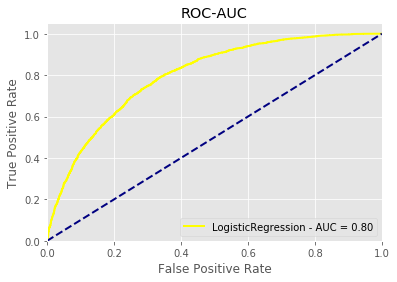

'Train Accuracy: 0.72. Test Accuracy: 0.72. Precision: 0.72. Recall: 0.66. AUC: 0.80'

In [250]:
get_scores(LogisticRegression, X_train_v2, X_test_v2, y_train, y_test, color = 'yellow')

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


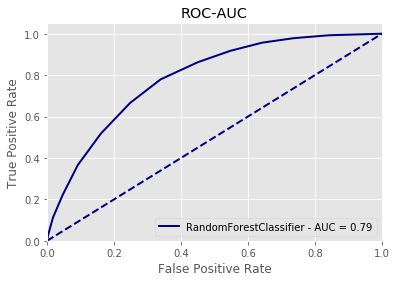

'Train Accuracy: 0.99. Test Accuracy: 0.71. OOB: 0.67. Precision: 0.71. Recall: 0.67. AUC: 0.79'

In [252]:
get_scores(RandomForestClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'navy', n_estimators = initial_trees_2, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

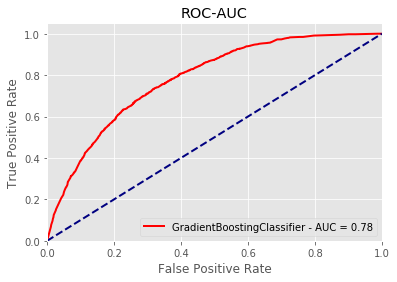

'Train Accuracy: 0.71. Test Accuracy: 0.71. Precision: 0.67. Recall: 0.74. AUC: 0.78'

In [253]:
get_scores(GradientBoostingClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'red', n_estimators = initial_trees_2, learning_rate = 0.1, random_state = 42)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


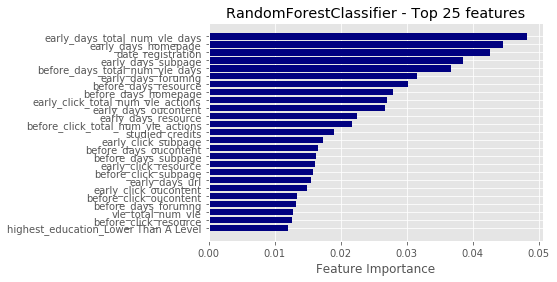

In [254]:
feature_importance(RandomForestClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'navy', n_estimators = initial_trees_2, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

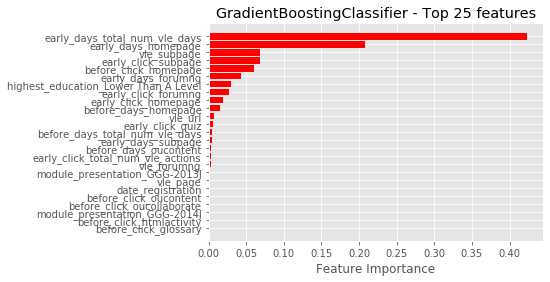

In [255]:
feature_importance(GradientBoostingClassifier, X_train_v2, X_test_v2, y_train, y_test, color = 'red', n_estimators = initial_trees_2, learning_rate = 0.1, random_state = 42)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


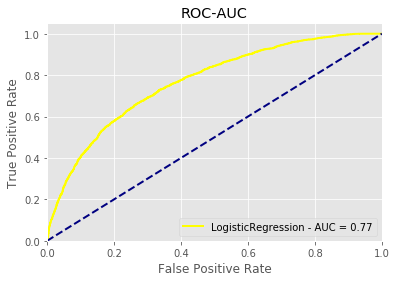

'Train Accuracy: 0.70. Test Accuracy: 0.70. Precision: 0.69. Recall: 0.65. AUC: 0.77'

In [274]:
get_scores(LogisticRegression, X_train_v3, X_test_v3, y_train, y_test, color = 'yellow')

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


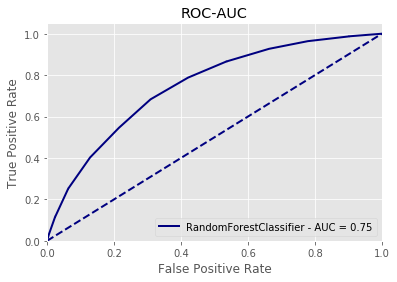

'Train Accuracy: 0.99. Test Accuracy: 0.69. OOB: 0.64. Precision: 0.66. Recall: 0.68. AUC: 0.75'

In [275]:
get_scores(RandomForestClassifier, X_train_v3, X_test_v3, y_train, y_test, color = 'navy', n_estimators = initial_trees_3, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

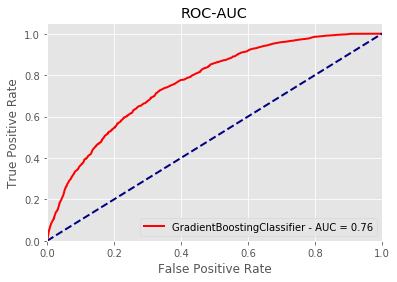

'Train Accuracy: 0.69. Test Accuracy: 0.69. Precision: 0.66. Recall: 0.72. AUC: 0.76'

In [277]:
get_scores(GradientBoostingClassifier, X_train_v3, X_test_v3, y_train, y_test, color = 'red', n_estimators = initial_trees_3, learning_rate = 0.1, random_state = 42)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


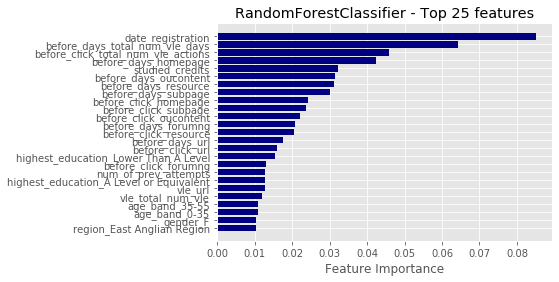

In [278]:
feature_importance(RandomForestClassifier, X_train_v3, X_test_v3, y_train, y_test, color = 'navy', n_estimators = initial_trees_3, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

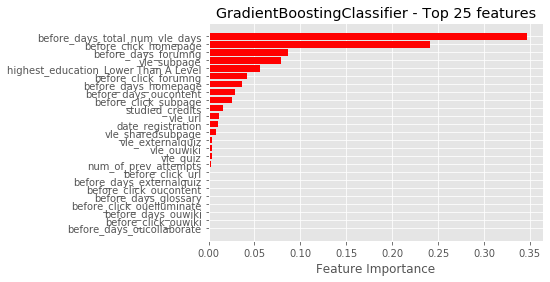

In [279]:
feature_importance(GradientBoostingClassifier, X_train_v3, X_test_v3, y_train, y_test, color = 'red', n_estimators = initial_trees_3, learning_rate = 0.1, random_state = 42)

### Want to revisit EDA to see what baseline predictions I could come up with to compare to models which don't use click data

In [ ]:
result.head()

In [ ]:
df_eda = result.drop(['final_result', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [ ]:
df_eda.columns

In [ ]:
cols = ['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'code_module']

In [ ]:
fig, axs = plt.subplots(3,3, figsize = (20,12))
fig.suptitle('Demographic Vars Final Result', x = 0.5, y = 1.05)

for i, ax in enumerate(axs.flatten()):
                       
    cross_t = pd.crosstab(df_eda[cols[i]], df_eda['final_result_edit'], rownames=[cols[i]])
    cross_t.apply(lambda r: r/r.sum(), axis=1).plot(kind="bar", ax=ax)
    ax.set_ylim(0,1)
    ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()   
fig.legend(handles, labels, loc='upper right')
plt.tight_layout();



* Gender/Disability: All Fail
* Code Module: AAA, EEE, GGG: Pass
* Age Band: 0-35 fail, all others" pass
* IMD Band - at and above 60-70%: pass
* Ireland, North Region, South East Region, South Region: Pass
* HE Qualification, A Level or Equivalent, Post Graduate Qual: Pass

* Gender & Disability

In [ ]:
# Gender and Disability --> predicting all fail
y_predict = np.zeros(len(y_test))

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re


In [ ]:
# Predicting All Pass --> predicting all pass
y_predict = np.ones(len(y_test))

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

In [ ]:
cross_t = pd.crosstab(df_eda['disability'], df_eda['final_result_edit'], rownames=['disability'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [ ]:
result_disability = pd.merge(df_eda, cross_tab, how='left', on=['disability'])                                                

In [ ]:
y_probas_disability = pd.merge(X_test, result_disability.Pass, how = 'left', left_index = True, right_index = True)['Pass']

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_disability) #take probas of positive class
auc(fpr, tpr)

* Age

In [ ]:
# Predicting anyone older than 35 passes, rest fail
y_predict = np.array(X_test['age_band_0-35'] == 0)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

* IMDB Band

In [ ]:
mask = (X_test['imd_band_60-70%'] == 1) | \
(X_test['imd_band_70-80%'] == 1) | \
(X_test['imd_band_80-90%'] == 1) | \
(X_test['imd_band_90-100%'] == 1) 

In [ ]:
# predicting anyone from imd band >60% passes, rest fail
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

In [ ]:
cross_t = pd.crosstab(df_eda['imd_band'], df_eda['final_result_edit'], rownames=['imd_band'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [ ]:
result_imdb = pd.merge(df_eda, cross_tab, how='left', on=['imd_band'])                                                

In [ ]:
y_probas_imdb = pd.merge(X_test, result_imdb.Pass, how = 'left', left_index = True, right_index = True)['Pass']

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_imdb) #take probas of positive class
auc(fpr, tpr)

* Module Presentation

In [ ]:
mask = (X_test['module_presentation_AAA-2013J'] == 1) | \
(X_test['module_presentation_AAA-2014J']==1) | \
(X_test['module_presentation_EEE-2013J']==1) | \
(X_test['module_presentation_EEE-2014B']==1) | \
(X_test['module_presentation_EEE-2014J']==1) | \
(X_test['module_presentation_GGG-2013J']==1) | \
(X_test['module_presentation_GGG-2014B']==1) | \
(X_test['module_presentation_GGG-2014J']==1)

In [ ]:
# predicting anyone from module AAA, EEE, or GGG pass
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

In [ ]:
cross_t = pd.crosstab(df_eda['module_presentation'], df_eda['final_result_edit'], rownames=['module_presentation'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [ ]:
result_module_presentation = pd.merge(df_eda, cross_tab, how='left', on=['module_presentation'])                                                

In [ ]:
y_probas_module_presentation = pd.merge(X_test, result_module_presentation.Pass, how = 'left', left_index = True, right_index = True)['Pass']

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_module_presentation) #take probas of positive class
auc(fpr, tpr)

* Region

In [ ]:
mask = (X_test['region_Ireland'] == 1) | \
(X_test['region_North Region']==1) | \
(X_test['region_South Region']==1) | \
(X_test['region_South East Region']==1)


In [ ]:
# predicting an`yone from Ireland, North Region, South East Region, South Region: Pass
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

* Highest Education

In [ ]:
mask = (X_test['highest_education_HE Qualification'] == 1) | \
(X_test['highest_education_A Level or Equivalent']==1) | \
(X_test['highest_education_Post Graduate Qualification']==1)

In [ ]:
# predicting HE Qualification, A Level or Equivalent, Post Graduate Qual: Pass
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

In [ ]:
cross_t = pd.crosstab(df_eda['highest_education'], df_eda['final_result_edit'], rownames=['highest_education'])
cross_tab = cross_t.apply(lambda r: r/r.sum(), axis=1)

In [ ]:
result_highest_education = pd.merge(df_eda, cross_tab, how='left', on=['highest_education'])                                                

In [ ]:
y_probas_highest_education = pd.merge(X_test, result_highest_education.Pass, how = 'left', left_index = True, right_index = True)['Pass']

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_highest_education) #take probas of positive class
auc(fpr, tpr)

In [ ]:
for i in lst:
    print(i)

In [ ]:
#create numeric plots
num = [f for f in df_eda.columns if df_eda.dtypes[f] != 'object']

nd = pd.melt(df_eda, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

* date_registraion
* date_unregistration
* Previous Attempts
* Studied Credits
* Num Assessments
* vle_total_num_vle (some num - maybe below and above 300)
* click_total_num_vle_actions (some num - maybe below and above 300)

* Date Registration

In [ ]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['date_registration'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels_5)

In [ ]:
y = df_eda.final_result_edit.apply(lambda x: 1 if x =='Pass' else 0)

In [ ]:
cross_tab = pd.concat([x,y], axis=1).groupby('date_registration').mean()

In [ ]:
cross_tab

In [ ]:
result_registration = pd.merge(x, cross_tab, how='left', on=['date_registration'])                                                


In [ ]:
y_probas_registration = pd.merge(X_test, result_registration.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_registration.fillna(0))
auc(fpr, tpr)

* Date Unregistration

In [ ]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['date_unregistration'],
                              q=5,
                              labels=bin_labels_5)

In [ ]:
x = x.cat.add_categories('registered')
x.fillna('registered', inplace =True) 


In [ ]:
cross_tab = pd.concat([x,y], axis=1).groupby('date_unregistration').mean()

In [ ]:
result_unregistration = pd.merge(x, cross_tab, how='left', on=['date_unregistration'])                                                


In [ ]:
y_probas_unregistration = pd.merge(X_test, result_unregistration.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas_unregistration)
auc(fpr, tpr)

* Num Assessments

In [ ]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['num_assessments'],
                              q=5,
                              labels=bin_labels_5)

In [ ]:
pd.concat([x,y], axis=1).groupby('num_assessments').mean()

* Total VLE

In [ ]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['vle_total_num_vle'],
                              q=5,
                              labels=bin_labels_5)

In [ ]:
cross_tab = pd.concat([x,y], axis=1).groupby('vle_total_num_vle').mean()

In [ ]:
result_vle = pd.merge(x, cross_tab, how='left', on=['vle_total_num_vle'])                                                
y_probas_vle = pd.merge(X_test, result_vle.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

fpr, tpr, thresholds = roc_curve(y_test, y_probas_vle.fillna(0))
auc(fpr, tpr)

* Total VLE Clicks

In [ ]:
bin_labels_5 = ['lowest', 'low', 'mid', 'high', 'highest']
x = pd.qcut(df_eda['click_total_num_vle_actions'],
                              q=5,
                              labels=bin_labels_5)

In [ ]:
cross_tab = pd.concat([x,y], axis=1).groupby('click_total_num_vle_actions').mean()

In [ ]:
result_vle_clicks = pd.merge(x, cross_tab, how='left', on=['click_total_num_vle_actions'])                                                
y_probas_vle_clicks = pd.merge(X_test, result_vle_clicks.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

fpr, tpr, thresholds = roc_curve(y_test, y_probas_vle_clicks.fillna(0))
auc(fpr, tpr)

* Studied Credits

In [ ]:
bin_labels_5 = ['low', 'mid', 'high']
x = pd.qcut(df_eda['studied_credits'],
                              q=3)


In [ ]:
cross_tab = pd.concat([x,y], axis=1).groupby('studied_credits').mean()

In [ ]:
mask = (X_test['studied_credits'] <60)

In [ ]:
# predicting Pass if studied credits below 60
y_predict = np.array(mask)

test_acc = accuracy_score(y_test, y_predict)
pre = precision_score(y_test, y_predict)
re = recall_score(y_test, y_predict)

test_acc, pre, re

In [ ]:
result_studied_credits = pd.merge(x, cross_tab, how='left', on=['studied_credits'])                                                
y_probas_studied_credits = pd.merge(X_test, result_studied_credits.final_result_edit, how = 'left', left_index = True, right_index = True)['final_result_edit']

fpr, tpr, thresholds = roc_curve(y_test, y_probas_studied_credits.fillna(0))
auc(fpr, tpr)

### Moving towards Refining Unregistration Info

In [ ]:
df_eda.date_unregistration.value_counts()

In [ ]:
x = pd.qcut(df_eda['date_unregistration'],
                              q=10)

In [ ]:
x.value_counts()

In [ ]:
x.value_counts().sum()

In [ ]:
len(df_eda)

In [ ]:
x.value_counts().sum()/len(df_eda)

* 30% of Students Withdraw


* 30% of withdrawals happen before class starts -> Remove those students
* Addtl 13% of withdrawals occur within first 12 days of class
* Should I remove all these students above

#### Running model taking out withdrawn students to see

In [287]:
result.shape

(32593, 140)

In [288]:
df_no_w = result[(result.date_unregistration>=0) | (result.date_unregistration.isna())]

In [289]:
df_no_w = df_no_w.drop(['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [290]:
df_no_w = pd.get_dummies(df_no_w)

In [291]:
df_no_w = df_no_w.drop(['final_result_edit_Fail'],axis = 1)
df_no_w = df_no_w.drop(['date_unregistration'],axis = 1)
y_no_w = df_no_w.pop('final_result_edit_Pass')
X_no_w = df_no_w


In [294]:

X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w = train_test_split(X_no_w, y_no_w, shuffle = True, test_size = 0.25, random_state = 42)

In [295]:
X_train_no_w = X_train_no_w.fillna(0)
X_test_no_w = X_test_no_w.fillna(0)


In [300]:
X_train_no_w = X_train_no_w.drop(str_cols+click_cols,axis = 1)
X_test_no_w = X_test_no_w.drop(str_cols+click_cols,axis = 1)

In [301]:
initial_trees_3 = int(np.sqrt(len(X_train_no_w.columns)))

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


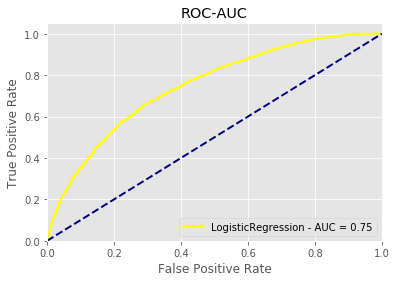

'Train Accuracy: 0.68. Test Accuracy: 0.68. Precision: 0.68. Recall: 0.70. AUC: 0.75'

In [302]:
get_scores(LogisticRegression, X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w, color = 'yellow', random_state = 42)


In [347]:
initial_trees_3

11

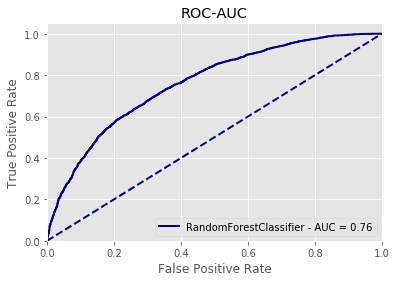

'Train Accuracy: 0.91. Test Accuracy: 0.69. OOB: 0.69. Precision: 0.68. Recall: 0.74. AUC: 0.76'

In [373]:
get_scores(RandomForestClassifier, X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w, color = 'navy',criterion = 'gini', n_estimators = 200, max_features = 0.25, oob_score = True, bootstrap = True,min_samples_leaf= 4,
min_samples_split= 2, random_state = 42, n_jobs = -1)

In [356]:
from sklearn.model_selection import GridSearchCV


In [355]:
model_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6],        
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],    
    'random_state': [42]}


In [357]:
rf_model = RandomForestClassifier(random_state=42)


In [361]:
clf = GridSearchCV(rf_model, model_params, cv=5, n_jobs = -1 , verbose = True)


In [362]:
model = clf.fit(X_train_no_w, y_train_no_w)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 77.1min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 79.9min finished


In [363]:
from pprint import pprint
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.25,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [368]:
predictions = model.predict(X_test_no_w)
y_probas = model.predict_proba(X_test_no_w)

In [370]:
fpr, tpr, thresholds = roc_curve(y_test_no_w, y_probas[:,1])
auc(fpr, tpr)

0.7612070779134353

In [376]:
rf_model = RandomForestClassifier(criterion = 'gini', n_estimators = 200, max_features = 0.25, oob_score = True, bootstrap = True,min_samples_leaf= 4)


Model Report
Accuracy (Train) : 0.9095
AUC Score (Train): 0.972477
CV Score : Mean - 0.7639762 | Std - 0.003670602 | Min - 0.7575079 | Max - 0.7686435


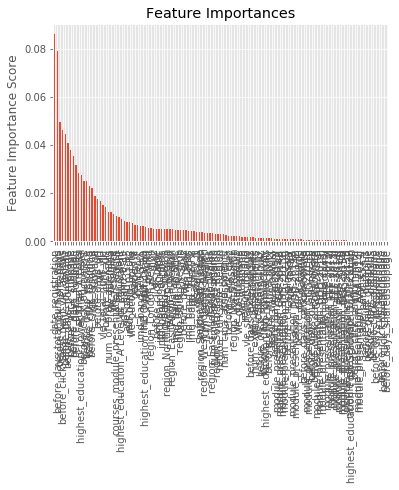

In [388]:
modelfit(rf_model, X_train_no_w, y_train_no_w, performCV=True, printFeatureImportance=True, cv_folds=5)

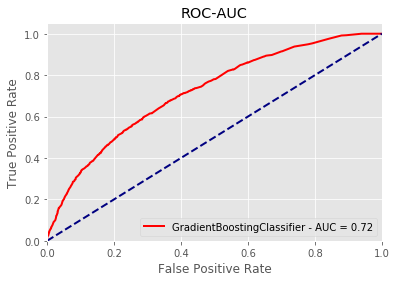

'Train Accuracy: 0.66. Test Accuracy: 0.65. Precision: 0.64. Recall: 0.73. AUC: 0.72'

In [305]:
get_scores(GradientBoostingClassifier, X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w, color = 'red', n_estimators = initial_trees_3, learning_rate = 0.1, random_state = 42)


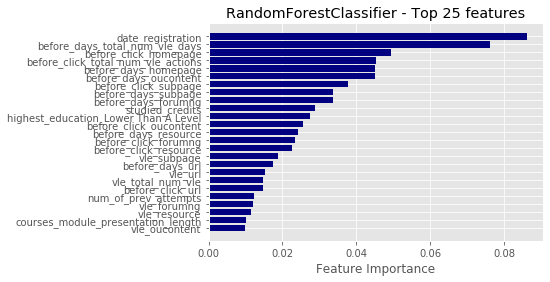

In [374]:
feature_importance(RandomForestClassifier, X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w, color = 'navy',criterion = 'gini', n_estimators = 200, max_features = 0.25, oob_score = True, bootstrap = True,min_samples_leaf= 4,
min_samples_split= 2, random_state = 42, n_jobs = -1)

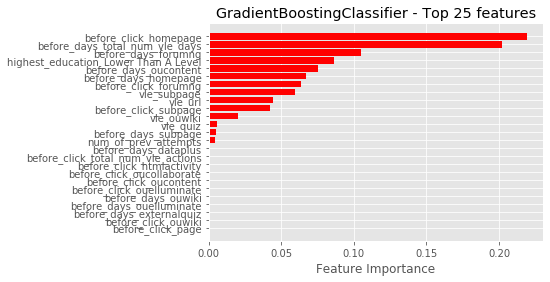

In [307]:
feature_importance(GradientBoostingClassifier, X_train_no_w, X_test_no_w, y_train_no_w, y_test_no_w, n_estimators = initial_trees_3, learning_rate = 0.1, random_state = 42)

In [308]:
df_no_w_2 = result[(result.date_unregistration>=12) | (result.date_unregistration.isna())]

In [309]:
df_no_w_2 = df_no_w_2.drop(['final_result', 'code_module', 'code_presentation', 'id_student', 'courses_date_time'], axis = 1)

In [310]:
df_no_w_2 = pd.get_dummies(df_no_w_2)

In [311]:
df_no_w_2 = df_no_w_2.drop(['final_result_edit_Fail'],axis = 1)
df_no_w_2 = df_no_w_2.drop(['date_unregistration'],axis = 1)
y_no_w_2 = df_no_w_2.pop('final_result_edit_Pass')
X_no_w_2 = df_no_w_2


In [312]:

X_train_no_w_2, X_test_no_w_2, y_train_no_w_2, y_test_no_w_2 = train_test_split(X_no_w_2, y_no_w_2, shuffle = True, test_size = 0.25, random_state = 42)

In [313]:
initial_trees_4 = int(np.sqrt(len(X_train_no_w_2.columns)))

In [314]:
X_train_no_w_2 = X_train_no_w_2.fillna(0)
X_test_no_w_2 = X_test_no_w_2.fillna(0)

In [316]:
X_train_no_w_2 = X_train_no_w_2.drop(click_cols,axis = 1)
X_test_no_w_2 = X_test_no_w_2.drop(click_cols,axis = 1)

/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


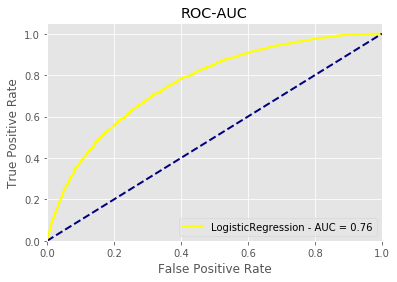

'Train Accuracy: 0.70. Test Accuracy: 0.69. Precision: 0.71. Recall: 0.73. AUC: 0.76'

In [317]:
get_scores(LogisticRegression, X_train_no_w_2, X_test_no_w_2, y_train_no_w_2, y_test_no_w_2, color = 'yellow', random_state = 42)


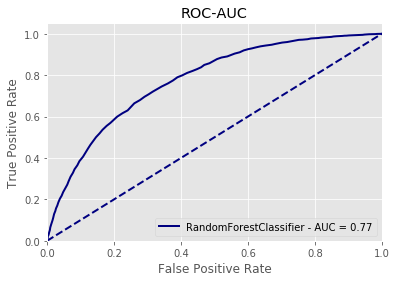

'Train Accuracy: 1.00. Test Accuracy: 0.70. OOB: 0.71. Precision: 0.70. Recall: 0.77. AUC: 0.77'

In [346]:
get_scores(RandomForestClassifier, X_train_no_w_2, X_test_no_w_2, y_train_no_w_2, y_test_no_w_2, color = 'navy', n_estimators = initial_trees_3**2, max_features = 25, oob_score = True, bootstrap = True, random_state = 42)

In [337]:
initial_trees_3

11

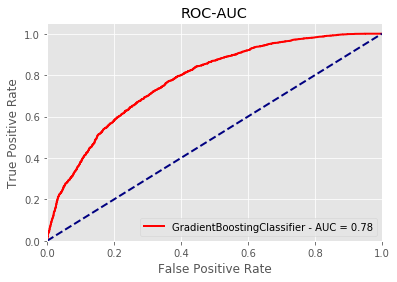

'Train Accuracy: 0.71. Test Accuracy: 0.71. Precision: 0.70. Recall: 0.79. AUC: 0.78'

In [344]:
get_scores(GradientBoostingClassifier, X_train_no_w_2, X_test_no_w_2, y_train_no_w_2, y_test_no_w_2, color = 'red', n_estimators = 500, learning_rate = .01, random_state = 42)


/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jaimeadybuncio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


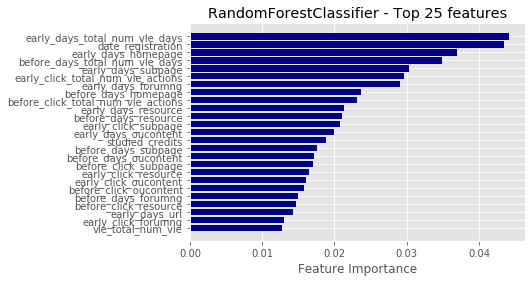

In [320]:
feature_importance(RandomForestClassifier, X_train_no_w_2, X_test_no_w_2, y_train_no_w_2, y_test_no_w_2, color = 'navy', n_estimators = initial_trees_3, max_features = 10, oob_score = True, bootstrap = True, random_state = 42)

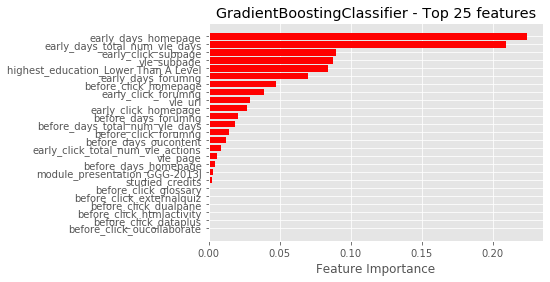

In [321]:
feature_importance(GradientBoostingClassifier, X_train_no_w_2, X_test_no_w_2, y_train_no_w_2, y_test_no_w_2, n_estimators = initial_trees_3, learning_rate = 0.1, random_state = 42)

### Model 1: Predicting Module-Presentation Outcome (Final Result from StudentInfo) - Classification
* Baseline Model - using avg
* Baseline Model - variant using demographic data
* Apply to Train-Test split
* Logistic
* RandomForestClassifier
* Gradient Boosting classifier
* xGBoostClassifier 
* Neural Nets?

In [ ]:
pd.plotting.scatter_matrix(result, figsize =(20,20));

### Model 2: Predicting Final Assessment Score - Regression